# Import Detectron2 & some Libraries

In [1]:
# detectron2 logger 설정
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# 자주 사용하는 라이브러리 임폴트
import numpy as np
import cv2
import random

# 자주 사용하는 detectron2 유틸 임폴트 
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

## GPU 확인하기

In [2]:
import torch
print('Available cuda device ', torch.cuda.is_available())
print('Current cuda device ', torch.cuda.current_device()) # check


Available cuda device  True
Current cuda device  0


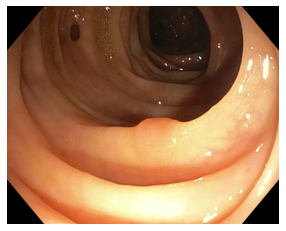

In [3]:
import matplotlib.pyplot as plt
im = cv2.imread("./trainData_EndoCV2021_5_Feb2021/data_C1/images_C1/100H0050.jpg")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

plt.imshow(im)
plt.axis('off')
plt.show()

## Make a Dataset

In [4]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
import itertools
from pycocotools import mask


def get_polyp_dicts(data_dirs):
    '''
        Dataset 만드는 부분
        input:
            data_dirs: List
        return: 
            dataset_dicts: Dictionary
    '''
    base_dir = './trainData_EndoCV2021_5_Feb2021/'
    dataset_dicts = []

    cnt = 0
    for data_dir in data_dirs:
        print("LOAD " + data_dir + " STARTED.........")

        data_dir_full_path = os.path.join(base_dir, data_dir)
        dir_names = sorted(os.listdir(data_dir_full_path))

        bbox_dir = os.path.join(data_dir_full_path, dir_names[0])
        bbox_img_dir = os.path.join(data_dir_full_path, dir_names[1])
        image_dir = os.path.join(data_dir_full_path, dir_names[2])
        mask_dir = os.path.join(data_dir_full_path, dir_names[3])


        image_filenames = sorted(os.listdir(image_dir))

        for image_filename in image_filenames:
            record = {}

            image_filename_full_path = os.path.join(image_dir, image_filename)
            height, width = cv2.imread(image_filename_full_path).shape[:2]

            record["file_name"] = image_filename_full_path
            record["height"] = height
            record["width"] = width
            record["image_id"] = cnt

            cnt += 1

            fn = os.path.splitext(image_filename)[0]
            bbox_filename_full_path = os.path.join(bbox_dir, fn + "_mask.txt")
            mask_filename_full_path = os.path.join(mask_dir, fn + "_mask.jpg")
      
            objs = []

            _mask = cv2.imread(mask_filename_full_path)        
            _mask = cv2.cvtColor(_mask, cv2.COLOR_BGR2GRAY)

            # _mask를 출력해보면 binary가 아님. 
            # 0, 1, 2, ... , 8 그리고 247, 248, ... , 255 값이 들어있는 것으로 확인. 
            # binarization이 필요.
            _mask[_mask < 128] = 0
            _mask[_mask > 128] = 1
            
            with open(bbox_filename_full_path) as f:
                contents = f.readlines()

                for anno in contents:
                    anno = anno.replace("\n", "")
                    strings = anno.split(' ')
                    # annotation 형태: polyp x_min y_min x_max y_max

                    if strings[0] == 'polyp':
                        # polyp이 있는 경우만 데이터셋에 추가
                        x_min = int(strings[1])
                        y_min = int(strings[2])
                        x_max = int(strings[3])
                        y_max = int(strings[4])
                        
                        # bounding box와 segmenation mask이 둘 다 1인 부분 찾기
                        # 하나의 image에 여러 polyp이 있는 경우
                        _bbox_img = np.zeros((height, width))
                        _bbox_img[y_min:y_max, x_min:x_max] = 1
                        
                        _mask_bbox = _bbox_img * _mask
                        
                        # binary segmentation mask를 detectron2에서 요구하는 형식(COCO’s compressed RLE format) 으로 변환
                        _mask_bbox = _mask_bbox.astype('uint8')
                        _mask_dict = mask.encode(np.asarray(_mask_bbox, order="F"))
                        
                        obj = {
                            "bbox": [x_min, y_min, x_max, y_max],
                            "bbox_mode": BoxMode.XYXY_ABS,
                            "category_id": 0,
                            "iscrowd": 0,
                            "segmentation": _mask_dict
                        }
                        objs.append(obj)

            record["annotations"] = objs
            dataset_dicts.append(record)
    return dataset_dicts

    
    
    

In [5]:
from detectron2.data import DatasetCatalog, MetadataCatalog
train_data_dirs = ['data_C2', 'data_C3', 'data_C4', 'data_C5']
val_data_dirs = ['data_C1']

DatasetCatalog.register("polyp_train", lambda: get_polyp_dicts(train_data_dirs))
MetadataCatalog.get("polyp_train").set(thing_classes=["polyp"])

DatasetCatalog.register("polyp_val", lambda: get_polyp_dicts(val_data_dirs))
MetadataCatalog.get("polyp_val").set(thing_classes=["polyp"])

polyp_metadata = MetadataCatalog.get("polyp_train")

# Train Dataset 체크하기 (without Augmentation)

LOAD data_C2 STARTED.........
LOAD data_C3 STARTED.........
LOAD data_C4 STARTED.........
LOAD data_C5 STARTED.........
./trainData_EndoCV2021_5_Feb2021/data_C3/images_C3/C3_EndoCV2021_00358.jpg


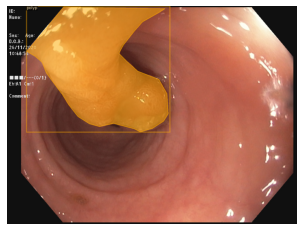

./trainData_EndoCV2021_5_Feb2021/data_C3/images_C3/C3_EndoCV2021_00240.jpg


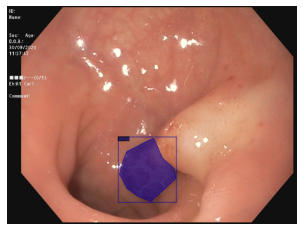

./trainData_EndoCV2021_5_Feb2021/data_C3/images_C3/C3_EndoCV2021_00104.jpg


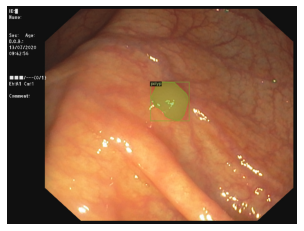

./trainData_EndoCV2021_5_Feb2021/data_C2/images_C2/EndoCV2021_001388.jpg


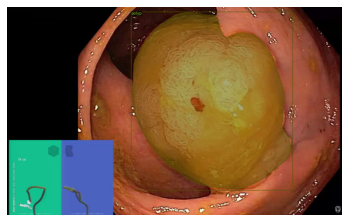

./trainData_EndoCV2021_5_Feb2021/data_C2/images_C2/EndoCV2021_001416.jpg


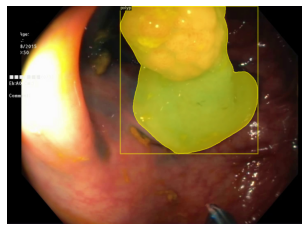

./trainData_EndoCV2021_5_Feb2021/data_C2/images_C2/EndoCV2021_001245.jpg


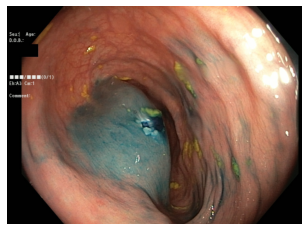

./trainData_EndoCV2021_5_Feb2021/data_C5/images_C5/EndoCV2021_C5_50000335.jpg


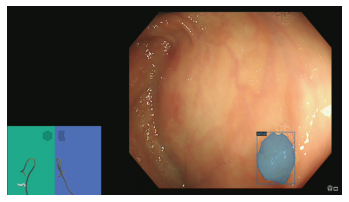

./trainData_EndoCV2021_5_Feb2021/data_C5/images_C5/EndoCV2021_C5_50000354.jpg


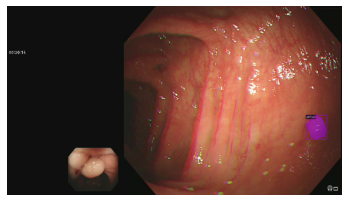

./trainData_EndoCV2021_5_Feb2021/data_C5/images_C5/EndoCV2021_C5_50000078.jpg


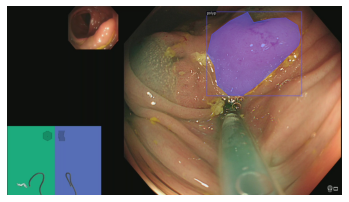

./trainData_EndoCV2021_5_Feb2021/data_C5/images_C5/EndoCV2021_C5_50000085.jpg


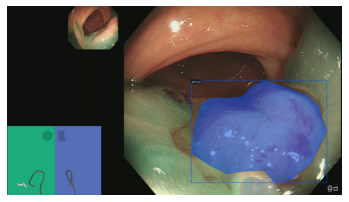

In [6]:
dataset_dicts = get_polyp_dicts(train_data_dirs)
for d in random.sample(dataset_dicts, 10):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=polyp_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    v_result = vis.get_image()[:, :, ::-1]
    v_result = cv2.cvtColor(v_result, cv2.COLOR_BGR2RGB)

    plt.imshow(v_result)
    plt.axis('off')
    plt.show()

## Data Augmentation

In [7]:
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
import copy
import torch

def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    image = utils.read_image(dataset_dict["file_name"], format="RGB")
    transform_list = [
#         T.Resize((800,600)),
        T.RandomBrightness(0.8, 1.8),
        T.RandomContrast(0.6, 1.3),
        T.RandomSaturation(0.8, 1.4),
#         T.RandomRotation(angle=[-90, 90], expand=False),
        T.RandomLighting(0.7),
        T.RandomFlip(prob=0.4, horizontal=False, vertical=True),
        T.RandomFlip(prob=0.4, horizontal=True, vertical=False)
    ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(
            obj, 
            transforms, 
            image.shape[:2]
        )
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2], mask_format = "bitmask")
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict

## Custom Trainer

In [8]:
from detectron2.engine import DefaultTrainer
from detectron2.data import build_detection_test_loader, build_detection_train_loader

class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

## Configuration Settings

In [9]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/myconfig/my_rcnn_X_101_32x8d_FPN_3x.yaml")
# cfg.merge_from_file("./detectron2_repo/configs/myconfig/my_mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("polyp_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 4
cfg.INPUT.MASK_FORMAT = 'bitmask'
cfg.INPUT.FORMAT = "RGB"
# cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/retinanet_R_50_FPN_3x/137849486/model_final_4cafe0.pkl"  # initialize from model zoo
# cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x/139653917/model_final_2d9806.pkl"
    
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 10000    # 300 iterations 정도면 충분합니다. 더 오랜 시간도 시도해보세요.
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # 풍선 데이터셋과 같이 작은 데이터셋에서는 이정도면 적당합니다.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # 클래스는 "풍선" 클래스 하나 뿐입니다.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# trainer = DefaultTrainer(cfg) 
trainer = CustomTrainer(cfg)


[02/15 13:36:13 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

## Visualizing an Augmented dataset

LOAD data_C2 STARTED.........
LOAD data_C3 STARTED.........
LOAD data_C4 STARTED.........
LOAD data_C5 STARTED.........
[02/15 13:37:39 d2.data.build]: Removed 111 images with no usable annotations. 1085 images left.
[02/15 13:37:39 d2.data.build]: Using training sampler TrainingSampler
[02/15 13:37:39 d2.data.common]: Serializing 1085 elements to byte tensors and concatenating them all ...
[02/15 13:37:39 d2.data.common]: Serialized dataset takes 1.36 MiB


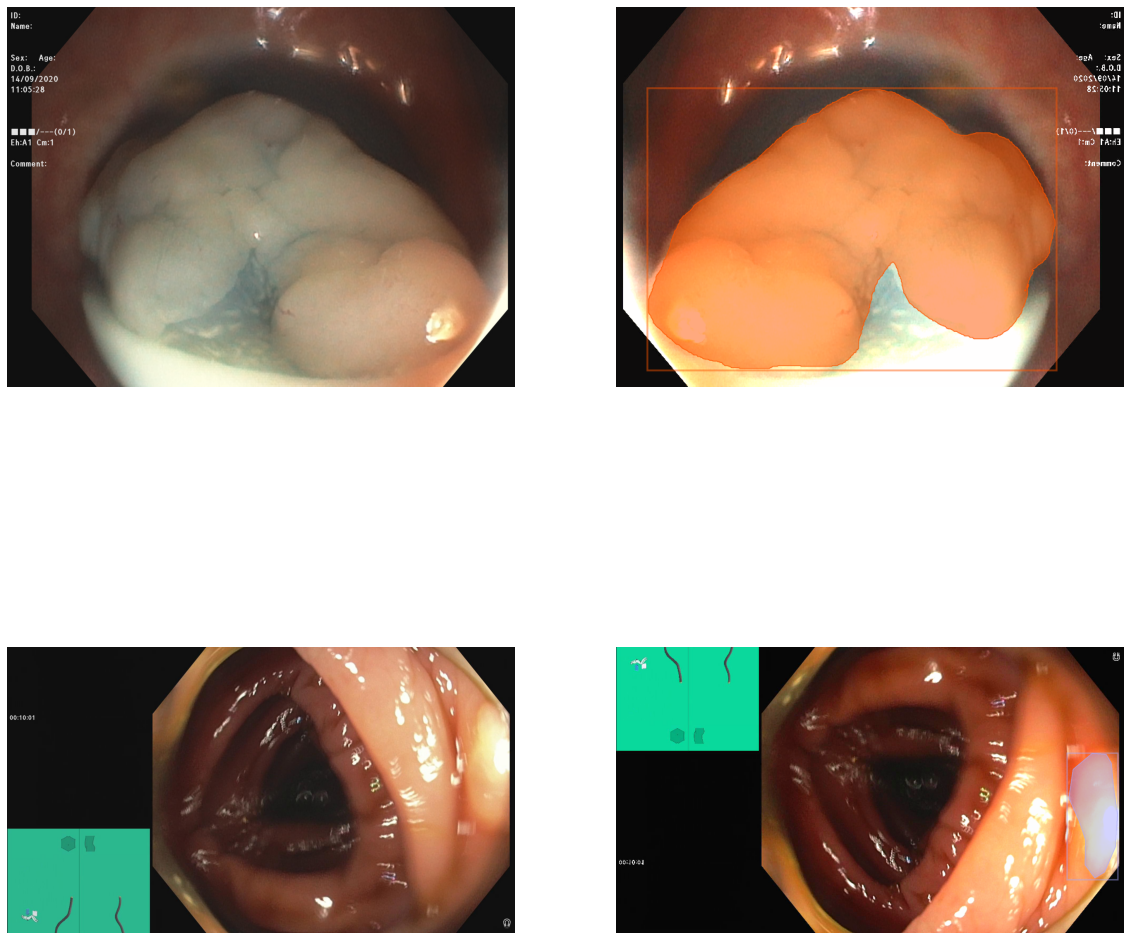

In [10]:
from detectron2.data import detection_utils as utils

train_data_loader = trainer.build_train_loader(cfg)
data_iter = iter(train_data_loader)
batch = next(data_iter)
rows, cols = 2, 2
plt.figure(figsize=(20,20))

for i, per_image in enumerate(batch[:]):
    plt.subplot(rows, cols, 2*i+1)
    # original image
    img_original = cv2.imread(per_image["file_name"])
    img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
    plt.imshow(img_original)
    plt.axis('off')

    plt.subplot(rows, cols, 2*i+2)
    
    # Pytorch tensor is in (C, H, W) format
    img = per_image["image"].permute(1, 2, 0).cpu().detach().numpy()
#     img = utils.convert_image_to_rgb(img, cfg.INPUT.FORMAT)

    visualizer = Visualizer(img, metadata=polyp_metadata, scale=0.5)

    target_fields = per_image["instances"].get_fields()
    labels = None
    vis = visualizer.overlay_instances(
        labels=labels,
        boxes=target_fields.get("gt_boxes", None),
        masks=target_fields.get("gt_masks", None),
        keypoints=target_fields.get("gt_keypoints", None),
    )
    v_result = cv2.cvtColor(vis.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)
    plt.imshow(v_result)
    plt.axis('off')
    

## Train

In [11]:
trainer.resume_or_load(resume=False)
trainer.train()

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[02/15 13:37:42 d2.engine.train_loop]: Starting training from iteration 0


/mnt/sda1/yeody/endocv2021/detectron2_repo/detectron2/modeling/roi_heads/fast_rcnn.py:103: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370141920/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  num_fg = fg_inds.nonzero().numel()


[02/15 13:38:13 d2.utils.events]:  eta: 4:19:40  iter: 19  total_loss: 1.804  loss_cls: 0.7443  loss_box_reg: 0.3222  loss_mask: 0.6929  loss_rpn_cls: 0.02417  loss_rpn_loc: 0.008651  time: 1.4898  data_time: 0.0422  lr: 4.9953e-06  max_mem: 10715M
[02/15 13:38:40 d2.utils.events]:  eta: 3:50:43  iter: 39  total_loss: 1.728  loss_cls: 0.6351  loss_box_reg: 0.3604  loss_mask: 0.6844  loss_rpn_cls: 0.01463  loss_rpn_loc: 0.009399  time: 1.4180  data_time: 0.0074  lr: 9.9902e-06  max_mem: 10715M
[02/15 13:39:10 d2.utils.events]:  eta: 4:07:31  iter: 59  total_loss: 1.559  loss_cls: 0.4923  loss_box_reg: 0.3669  loss_mask: 0.6581  loss_rpn_cls: 0.01447  loss_rpn_loc: 0.01013  time: 1.4352  data_time: 0.0075  lr: 1.4985e-05  max_mem: 10715M
[02/15 13:39:40 d2.utils.events]:  eta: 4:10:08  iter: 79  total_loss: 1.393  loss_cls: 0.3574  loss_box_reg: 0.3102  loss_mask: 0.629  loss_rpn_cls: 0.02147  loss_rpn_loc: 0.01459  time: 1.4512  data_time: 0.0071  lr: 1.998e-05  max_mem: 10715M
[02/15 1

In [12]:
# # %load_ext tensorboard
# %reload_ext tensorboard
# %tensorboard --logdir output

# # %load_ext tensorboard


## Visualizing results of a validation dataset

In [13]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("polyp_val", )
predictor = DefaultPredictor(cfg)

LOAD data_C1 STARTED.........
./trainData_EndoCV2021_5_Feb2021/data_C1/images_C1/278OLCV1_100H0012.jpg


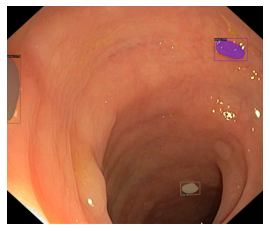

./trainData_EndoCV2021_5_Feb2021/data_C1/images_C1/556OLCV1_100H0012.jpg


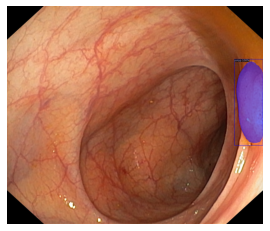

./trainData_EndoCV2021_5_Feb2021/data_C1/images_C1/419OLCV1_100H0026.jpg


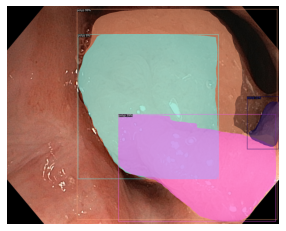

./trainData_EndoCV2021_5_Feb2021/data_C1/images_C1/445OLCV1_100H0010.jpg


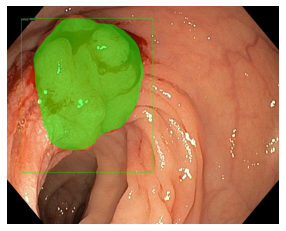

./trainData_EndoCV2021_5_Feb2021/data_C1/images_C1/134OLCV1_100H0010.jpg


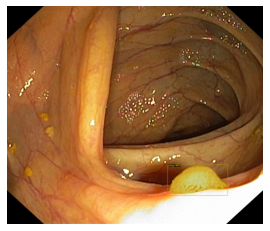

./trainData_EndoCV2021_5_Feb2021/data_C1/images_C1/887OLCV1_100H0002.jpg


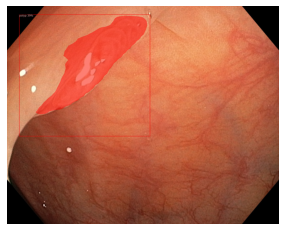

./trainData_EndoCV2021_5_Feb2021/data_C1/images_C1/615OLCV1_100H0024.jpg


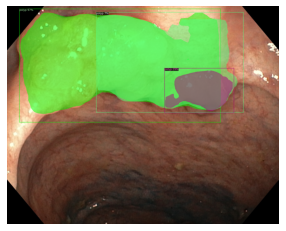

./trainData_EndoCV2021_5_Feb2021/data_C1/images_C1/459OLCV1_100H0016.jpg


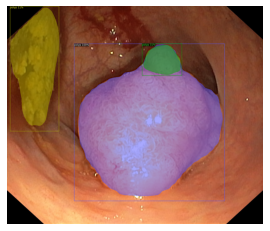

./trainData_EndoCV2021_5_Feb2021/data_C1/images_C1/732OLCV1_100H0016.jpg


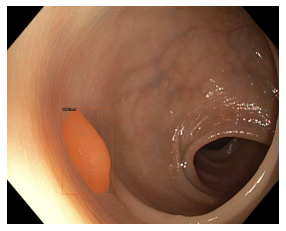

./trainData_EndoCV2021_5_Feb2021/data_C1/images_C1/431OLCV1_100S0007.jpg


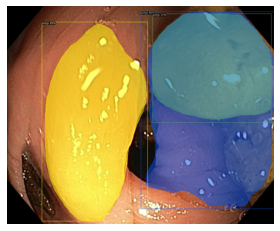

In [14]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_polyp_dicts(val_data_dirs)

for d in random.sample(dataset_dicts, 10):    
    print(d["file_name"])
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=polyp_metadata, 
                   scale=2.0
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    v_result = v.get_image()[:, :, ::-1]
    v_result = cv2.cvtColor(v_result, cv2.COLOR_BGR2RGB)

    plt.imshow(v_result)
    plt.axis('off')
    plt.show()

## Evaluation (COCO Evaluator)

In [15]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("polyp_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "polyp_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [02/15 17:50:20 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[02/15 17:50:20 d2.evaluation.coco_evaluation]: 'polyp_val' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
WARNING [02/15 17:50:20 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output/polyp_val_coco_format.json'. You need to clear the cache file if your dataset has been modified.
LOAD data_C1 STARTED.........
[02/15 17:50:29 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   polyp    | 532          |
|            |              |
[02/15 17:50:29 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[02/15 17:50:29 d2.data.common]: Serializing 256 elemen

OrderedDict([('bbox',
              {'AP': 32.729399314598695,
               'AP50': 45.1750820491057,
               'AP75': 36.08206199627399,
               'APs': 0.0,
               'APm': 23.869355031223193,
               'APl': 33.539533775275856}),
             ('segm',
              {'AP': 36.70578958719343,
               'AP50': 51.73148361029671,
               'AP75': 38.908239302808916,
               'APs': 0.0,
               'APm': 25.046271820276655,
               'APl': 37.848025227505836})])